Run with: sudo docker run --gpus all -it --rm -v $(pwd):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:2.12.0-gpu-jupyter

In [1]:
# GB: Adding compatibility check
import cnn2snn
import akida as ak
import os

# Change Akida version
os.environ["CNN2SNN_TARGET_AKIDA_VERSION"] = "v1"

# Double-check Avida version
print(' Akida version: ', cnn2snn.get_akida_version())

# # And HW compatibility?
# myDevice = ak.devices()[0]
# print("Device: ", myDevice.desc)
# x = cnn2snn.check_model_compatibility(model=model_keras, device=myDevice)
# print("Non compatibilities: ", x)

2024-10-16 08:53:04.027098: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 08:53:04.235685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 08:53:04.235712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 08:53:04.265194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 08:53:04.327444: I tensorflow/core/platform/cpu_feature_guar

 Akida version:  AkidaVersion.v1


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from glob import glob
from PIL import Image
import shutil
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import warnings

from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


seed = (4,2)

In [3]:
# os.chdir('notebooks/Documents/GitHub/GENG5551-Akida-Chip')
os.getcwd()

'/home/22489437/Documents/GitHub/GENG5551-Akida-Chip'

In [4]:
df = pd.read_csv('archive/HAM10000_metadata.csv')

size = (64, 64)

In [5]:
base_dir = './archive'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [6]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size)))

In [7]:
df = df[['dx', 'image']]

In [8]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [9]:
df_nv = df[df['dx'] == 'nv']
df_df = df[df['dx'] == 'df']
vasc_df = df[df['dx'] == 'vasc']
akiec_df = df[df['dx'] == 'akiec']
bcc_df = df[df['dx'] == 'bcc']
bkl_df = df[df['dx'] == 'bkl']
mel_df = df[df['dx'] == 'mel']

# Data Augmentation

In [10]:
def aug_brightness(img_arr):
    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [11]:
def aug_contrast(img_arr):
    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [12]:
def aug_flip_left_right(img_arr):
    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)

    return aug_arr

In [13]:
def aug_flip_up_down(img_arr):
    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)

    return aug_arr

In [14]:
def aug_hue(img_arr):
    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [15]:
def aug_saturation(img_arr):
    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [16]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [17]:
def random_augmentation(images, dx, num_of_samples):
    new_images = []
    all_indices = []
    while (len(new_images) < num_of_samples):
        indices = np.random.randint(images.shape[0], size=6)
        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))
        r = [np.array(tensor) for tensor in r]
        new_images.extend(r)
        all_indices.extend(indices)
        clear_output(wait=True)
        print(str(len(new_images)) + '/' + str(num_of_samples))

    new_images = pd.DataFrame({'dx': dx, 'image': new_images})

    return all_indices, new_images

In [18]:
df_images = df_df['image']
df_indices, df_new_images = random_augmentation(df_images, 'df', 700)

702/700


In [19]:
vasc_images = vasc_df['image']
vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', 700)

702/700


In [20]:
akiec_images = akiec_df['image']
akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', 1000)

1002/1000


In [21]:
bcc_images = bcc_df['image']
bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', 1200)

1200/1200


In [22]:
bkl_images = bkl_df['image']
bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', 1400)

1404/1400


In [23]:
mel_images = mel_df['image']
mel_indices, mel_new_images = random_augmentation(mel_images, 'mel', 1400)

1404/1400


In [24]:
new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images], axis=0).reset_index(drop=True)
aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [25]:
pd.DataFrame(aug_df['dx'].value_counts()).reset_index()

,dx,count
0,nv,6705
1,mel,2517
2,bkl,2503
3,bcc,1714
4,akiec,1329
5,vasc,844
6,df,817


In [26]:
labelEncoder = LabelEncoder()
aug_df['label'] = labelEncoder.fit_transform(aug_df['dx'])

In [27]:
x = np.asarray(aug_df['image'].to_list())
y = to_categorical(aug_df['label'], num_classes=7)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42, shuffle=True)

In [28]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Count the occurrences of each class in training and testing sets
train_counts = pd.Series(y_train_labels).value_counts().sort_index()
test_counts = pd.Series(y_test_labels).value_counts().sort_index()

# Display the counts
print("Training Set Class Distribution:")
print(train_counts)

print("\nTesting Set Class Distribution:")
print(test_counts)

Training Set Class Distribution:
0    1054
1    1366
2    2013
3     672
4    2044
5    5317
6     677
Name: count, dtype: int64

Testing Set Class Distribution:
0     275
1     348
2     490
3     145
4     473
5    1388
6     167
Name: count, dtype: int64


**SMOTE TECHNIQUE**

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [30]:
# Assuming x_train, y_train, x_test, y_test are already defined
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


In [31]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)


In [32]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train_reshaped, y_train.argmax(axis=1))


In [33]:
x_train_smote = x_train_smote.reshape(x_train_smote.shape[0], 64, 64, 3)
y_train_smote = tf.keras.utils.to_categorical(y_train_smote, num_classes=7)


# Model Edge Training

In [34]:
os.environ["CNN2SNN_TARGET_AKIDA_VERSION"] = "v1"

In [91]:
from akida_models import load_model


model_path = 'model_akida.fbz'

model_akida = load_model(model_path)

In [92]:
# from tensorflow.keras.models import load_model

# model_path = 'initial_model83.h5'
# model = load_model(model_path)

# model_quantized = cnn2snn.quantize(model,
#                                    weight_quantization=4,
#                                    activ_quantization=4,
#                                    input_weight_quantization=8)

# model_quantized = cnn2snn.quantize_layer(model_quantized, 'spike_generator/relu', 1)

In [93]:
# from cnn2snn import convert

# model_akida = convert(model_quantized)

In [94]:
from akida import AkidaUnsupervised
from akida import FullyConnected, SeparableConvolutional
from cnn2snn import quantize_layer

# Replace the last layer by a classification layer
num_classes = 7
num_neurons_per_class = 5
num_weights = 512 # Refer to the bottom of working_cnn.ipynb for reason 
model_akida.pop_layer()

layer_fc = FullyConnected(name='akida_edge_layer',
                          units=num_classes * num_neurons_per_class,
                          activation=False)
model_akida.add(layer_fc)

model_akida.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[64, 64, 3]  [1, 1, 35]    1          13    
______________________________________________

___________________________________________________________________
Layer (type)                    Output shape   Kernel shape      

============== SW/conv2d-akida_edge_layer (Software) ==============

conv2d (InputConv.)             [64, 64, 32]   (3, 3, 3, 32)     
___________________________________________________________________
conv2d_1 (Conv.)                [32, 32, 32]   (3, 3, 32, 32)    
___________________________________________________________________
conv2d_2 (Conv.)                [32, 32, 64]   (3, 3, 32, 64)    
___________________________________________________________________
conv2d_3 (Conv.)                [16, 16, 64]   (3, 3, 64, 64)    
___________________________________________________________________
conv2d_4 (Conv.)            

In [95]:
model_akida.compile(optimizer=AkidaUnsupervised(num_weights=num_weights,
                                             num_classes=num_classes,
                                             learning_competition=0.1))

model_akida.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[64, 64, 3]  [1, 1, 35]    1          13    
______________________________________________

___________________________________________________________________
Layer (type)                    Output shape   Kernel shape      

============== SW/conv2d-akida_edge_layer (Software) ==============

conv2d (InputConv.)             [64, 64, 32]   (3, 3, 3, 32)     
___________________________________________________________________
conv2d_1 (Conv.)                [32, 32, 32]   (3, 3, 32, 32)    
___________________________________________________________________
conv2d_2 (Conv.)                [32, 32, 64]   (3, 3, 32, 64)    
___________________________________________________________________
conv2d_3 (Conv.)                [16, 16, 64]   (3, 3, 64, 64)    
___________________________________________________________________
conv2d_4 (Conv.)            

In [96]:
batch_size = 32
# Convert x_train_smote to uint8 if needed
x_train_smote = x_train_smote.astype(np.uint8)

# Convert one-hot encoded y_train_smote to class indices (integer labels)
y_train_smote_int = np.argmax(y_train_smote, axis=1).astype(np.int32)


num_batches = int(np.ceil(x_train.shape[0] / batch_size))
for i in range(num_batches):
    s = slice(i * batch_size, (i + 1) * batch_size)
    model_akida.fit(x_train_smote[s], y_train_smote_int[s])



In [97]:
model_akida.save('model_edge_trained.fbz')

In [98]:
from tensorflow.image import resize_with_crop_or_pad
from time import time
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Pick a random index from the training dataset
random_index = np.random.randint(0, x_train_smote.shape[0])

# Select the random image and its corresponding true label
random_image = x_train_smote[random_index]
true_label = np.argmax(y_train_smote[random_index])

# Preprocess the random image (resize with padding to match input size of the model)
padded_image = resize_with_crop_or_pad(random_image, 64, 64)

# Get the predicted label from the model
predicted_label = model_akida.predict_classes(np.expand_dims(padded_image, axis=0), num_classes=7)

# Print the predicted and true labels
print(f'Predicted label: {class_names[predicted_label[0]]}')
print(f'True label: {class_names[true_label]}')

Predicted label: nv
True label: df


In [99]:
# # Convert x_train_smote to uint8 if needed
# x_test = x_test.astype(np.uint8)

# # Convert one-hot encoded y_train_smote to class indices (integer labels)
# # y_test_labels = np.argmax(y_test_labels, axis=1).astype(np.int32)

# # Evaluate the model on the test dataset
# predictions = np.zeros(x_test.shape[0])

# # Loop through the training data and get predictions
# for i in range(x_test.shape[0]):
#     padded_image = resize_with_crop_or_pad(x_test[i], 64, 64)
#     predictions[i] = model_akida.predict_classes(np.expand_dims(padded_image,
#                                                              axis=0),
#                                               num_classes=7)

# # Get true labels in a flat format
# true_labels = y_test_labels

# # Calculate overall accuracy
# accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)

# print(f'Accuracy on the training data (SMOTE): {accuracy:.2f}%')

# One-shot learning

In [44]:
from akida_models import load_model

model_akida = load_model('model_edge_trained_6.fbz')

In [35]:
from PIL import Image
import numpy as np 
import pandas as pd

def load_and_convert_image(image_path, size=(64, 64)):
    """
    Load an image from a given path, resize it, and convert it into a NumPy array.
    
    Parameters:
    - image_path: str, path to the image file
    - size: tuple, target size to resize the image (width, height)
    
    Returns:
    - np.ndarray, the image as a NumPy array with shape (width, height, channels)
    """
    # Open the image
    img = Image.open(image_path)
    
    # Resize the image
    img_resized = img.resize(size)
    
    # Convert the image to a NumPy array
    img_array = np.asarray(img_resized)
    
    return img_array

In [46]:
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [47]:
import os
from tensorflow.image import resize_with_crop_or_pad


# new_image_path = 'scar/ISIC_5147305.jpg'
# label = 'scar'

new_image_path = 'seborrheic_k/ISIC_1773560.jpg'
label = 'seborrheic_k'
model_akida.add_classes(1)

for file in os.listdir('seborrheic_k/'):
    image = load_and_convert_image(f"seborrheic_k/{file}")
    image = np.expand_dims(image, axis=0)  
    model_akida.fit(image, len(class_names))

class_names.append(label)

print(f"Class '{label}' added to the model. Total classes: {len(class_names)}")


Class 'seborrheic_k' added to the model. Total classes: 8


In [48]:
image = load_and_convert_image("seborrheic_k/ISIC_8541813.jpg")
true_label = 7

padded_image = resize_with_crop_or_pad(image, 64, 64)
predicted_label = model_akida.predict_classes(np.expand_dims(padded_image, axis=0), num_classes=7)

print(f'Predicted label: {class_names[predicted_label[0]]}')
print(f'True label: {class_names[true_label]}')

Predicted label: seborrheic_k
True label: seborrheic_k


In [49]:
for file in os.listdir('seborrheic_k/'):
    image = load_and_convert_image(f"seborrheic_k/{file}")
    true_label = 7

    # Preprocess the random image (resize with padding to match input size of the model)
    padded_image = resize_with_crop_or_pad(image, 64, 64)

    # Get the predicted label from the model
    predicted_label = model_akida.predict_classes(np.expand_dims(padded_image, axis=0), num_classes=7)

    # Print the predicted and true labels
    print(f'Predicted label: {class_names[predicted_label[0]]}')
    # print(f'True label: {class_names[true_label]}')

Predicted label: akiec
Predicted label: seborrheic_k
Predicted label: seborrheic_k
Predicted label: seborrheic_k
Predicted label: seborrheic_k
Predicted label: seborrheic_k
Predicted label: seborrheic_k
Predicted label: seborrheic_k
Predicted label: seborrheic_k
Predicted label: df
Predicted label: seborrheic_k
Predicted label: seborrheic_k
Predicted label: seborrheic_k
Predicted label: seborrheic_k
Predicted label: seborrheic_k


In [36]:
from akida_models import load_model
from akida import AkidaUnsupervised
from akida import FullyConnected, SeparableConvolutional
from cnn2snn import quantize_layer
import os
from tensorflow.image import resize_with_crop_or_pad

num_neurons = np.arange(1, 51)
num_neurons2 = [100, 150, 200, 250, 300, 350, 400, 450, 500]
merged_neurons = np.concatenate((num_neurons, num_neurons2))

original_accuracy = []
one_shot_accuracy = []


for neuron in num_neurons:
    # Load model 
    model_path = 'model_akida.fbz'
    model_akida = load_model(model_path)

    num_classes = 7
    num_neurons_per_class = neuron
    num_weights = 512 
    model_akida.pop_layer()

    layer_fc = FullyConnected(name='akida_edge_layer',
                            units=num_classes * num_neurons_per_class,
                            activation=False)
    model_akida.add(layer_fc)

    model_akida.compile(optimizer=AkidaUnsupervised(num_weights=num_weights,
                                             num_classes=num_classes,
                                             learning_competition=0.1))
    
    batch_size = 32
    # Convert x_train_smote to uint8 if needed
    x_train_smote = x_train_smote.astype(np.uint8)

    # Convert one-hot encoded y_train_smote to class indices (integer labels)
    y_train_smote_int = np.argmax(y_train_smote, axis=1).astype(np.int32)


    num_batches = int(np.ceil(x_train.shape[0] / batch_size))
    for i in range(num_batches):
        s = slice(i * batch_size, (i + 1) * batch_size)
        model_akida.fit(x_train_smote[s], y_train_smote_int[s])

    model_akida.save(f"models/edge_models/model_edge_trained_{neuron}.fbz")

    # Convert x_train_smote to uint8 if needed
    x_test = x_test.astype(np.uint8)

    # Evaluate the model on the test dataset
    predictions = np.zeros(x_test.shape[0])

    # Loop through the training data and get predictions
    for i in range(x_test.shape[0]):
        padded_image = resize_with_crop_or_pad(x_test[i], 64, 64)
        predictions[i] = model_akida.predict_classes(np.expand_dims(padded_image,
                                                                axis=0),
                                                num_classes=7)

    # Get true labels in a flat format
    true_labels = y_test_labels

    # Calculate overall accuracy
    accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)

    print(f'Neurons: {neuron}, Accuracy: {accuracy:.2f}%')
    original_accuracy.append(accuracy)

    
    class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

    label = 'seborrheic_k'
    model_akida.add_classes(1)

    for file in os.listdir('seborrheic_k/'):
        image = load_and_convert_image(f"seborrheic_k/{file}")
        image = np.expand_dims(image, axis=0)  
        model_akida.fit(image, len(class_names))

    class_names.append(label)

    correct_predictions = 0
    total_images = 0

    for file in os.listdir('seborrheic_k/'):
        image = load_and_convert_image(f"seborrheic_k/{file}")
        true_label = 7  # Seborrheic keratosis corresponds to label 7

        padded_image = resize_with_crop_or_pad(image, 64, 64)
        predicted_label = model_akida.predict_classes(np.expand_dims(padded_image, axis=0), num_classes=7)

        if predicted_label[0] == true_label:
            correct_predictions += 1

        total_images += 1

    accuracy = correct_predictions / total_images if total_images > 0 else 0

    print(f"{correct_predictions}/{total_images}, Accuracy: {accuracy * 100:.2f}")
    one_shot_accuracy.append(accuracy)


Neurons: 1, Accuracy: 58.70%
9/15, Accuracy: 60.00
Neurons: 2, Accuracy: 59.71%
12/15, Accuracy: 80.00
Neurons: 3, Accuracy: 61.90%
12/15, Accuracy: 80.00
Neurons: 4, Accuracy: 60.10%
14/15, Accuracy: 93.33
Neurons: 5, Accuracy: 63.66%
12/15, Accuracy: 80.00
Neurons: 6, Accuracy: 62.69%
13/15, Accuracy: 86.67
Neurons: 7, Accuracy: 64.33%
0/15, Accuracy: 0.00
Neurons: 8, Accuracy: 67.41%
6/15, Accuracy: 40.00
Neurons: 9, Accuracy: 64.52%
3/15, Accuracy: 20.00
Neurons: 10, Accuracy: 63.09%
2/15, Accuracy: 13.33
Neurons: 11, Accuracy: 64.88%
1/15, Accuracy: 6.67
Neurons: 12, Accuracy: 66.22%
3/15, Accuracy: 20.00
Neurons: 13, Accuracy: 63.97%
12/15, Accuracy: 80.00
Neurons: 14, Accuracy: 64.06%
0/15, Accuracy: 0.00
Neurons: 15, Accuracy: 67.04%
4/15, Accuracy: 26.67
Neurons: 16, Accuracy: 65.03%
4/15, Accuracy: 26.67
Neurons: 17, Accuracy: 65.25%
0/15, Accuracy: 0.00
Neurons: 18, Accuracy: 65.98%
1/15, Accuracy: 6.67
Neurons: 19, Accuracy: 64.67%
1/15, Accuracy: 6.67
Neurons: 20, Accuracy

In [43]:
from akida_models import load_model
from akida import AkidaUnsupervised
from akida import FullyConnected, SeparableConvolutional
from cnn2snn import quantize_layer
import os
from tensorflow.image import resize_with_crop_or_pad

num_neurons = np.arange(1, 51)
original_accuracy = []
one_shot_accuracy = []
seven_classes_accuracy = []

for neuron in num_neurons:
    # load model
    file_path = f"models/edge_models/model_edge_trained_{neuron}.fbz"
    model_akida = load_model(file_path)

    class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

    x_test = x_test.astype(np.uint8)

    # Evaluate the model on the test dataset
    predictions = np.zeros(x_test.shape[0])
    # Loop through the training data and get predictions
    for i in range(x_test.shape[0]):
        padded_image = resize_with_crop_or_pad(x_test[i], 64, 64)
        predictions[i] = model_akida.predict_classes(np.expand_dims(padded_image,
                                                                axis=0),
                                                num_classes=7)
    # Get true labels in a flat format
    true_labels = y_test_labels
    # Calculate overall accuracy
    before_accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)

    original_accuracy.append(before_accuracy)

    label = 'seborrheic_k'
    model_akida.add_classes(1)

    for file in os.listdir('seborrheic_k/'):
        image = load_and_convert_image(f"seborrheic_k/{file}")
        image = np.expand_dims(image, axis=0)  
        model_akida.fit(image, len(class_names))

    class_names.append(label)

    correct_predictions = 0
    total_images = 0

    for file in os.listdir('seborrheic_k/'):
        image = load_and_convert_image(f"seborrheic_k/{file}")
        true_label = 7  # Seborrheic keratosis corresponds to label 7

        padded_image = resize_with_crop_or_pad(image, 64, 64)
        predicted_label = model_akida.predict_classes(np.expand_dims(padded_image, axis=0), num_classes=7)

        if predicted_label[0] == true_label:
            correct_predictions += 1

        total_images += 1

    sebk_accuracy = correct_predictions / total_images if total_images > 0 else 0

    print(f"{correct_predictions}/{total_images}")
    one_shot_accuracy.append(sebk_accuracy * 100)

    # Evaluate the model on the test dataset
    predictions = np.zeros(x_test.shape[0])
    # Loop through the training data and get predictions
    for i in range(x_test.shape[0]):
        padded_image = resize_with_crop_or_pad(x_test[i], 64, 64)
        predictions[i] = model_akida.predict_classes(np.expand_dims(padded_image,
                                                                axis=0),
                                                num_classes=8)
    # Get true labels in a flat format
    true_labels = y_test_labels
    # Calculate overall accuracy
    after_accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)

    seven_classes_accuracy.append(after_accuracy)

    print(f"Neurons: {neuron}, Before Accuracy: {before_accuracy:.2f}%, One-shot Accuracy: {sebk_accuracy * 100:.2f}%, After Accuracy: {after_accuracy:.2f}%")

9/15
Neurons: 1, Before Accuracy: 57.91%, One-shot Accuracy: 60.00%, After Accuracy: 54.41%
10/15
Neurons: 2, Before Accuracy: 58.58%, One-shot Accuracy: 66.67%, After Accuracy: 57.46%
11/15
Neurons: 3, Before Accuracy: 60.23%, One-shot Accuracy: 73.33%, After Accuracy: 58.43%
15/15
Neurons: 4, Before Accuracy: 59.80%, One-shot Accuracy: 100.00%, After Accuracy: 58.13%
12/15
Neurons: 5, Before Accuracy: 61.29%, One-shot Accuracy: 80.00%, After Accuracy: 59.86%
13/15
Neurons: 6, Before Accuracy: 61.69%, One-shot Accuracy: 86.67%, After Accuracy: 60.65%
0/15
Neurons: 7, Before Accuracy: 64.46%, One-shot Accuracy: 0.00%, After Accuracy: 63.82%
0/15
Neurons: 8, Before Accuracy: 66.98%, One-shot Accuracy: 0.00%, After Accuracy: 66.52%
0/15
Neurons: 9, Before Accuracy: 64.49%, One-shot Accuracy: 0.00%, After Accuracy: 63.72%
1/15
Neurons: 10, Before Accuracy: 62.36%, One-shot Accuracy: 6.67%, After Accuracy: 61.72%
4/15
Neurons: 11, Before Accuracy: 64.85%, One-shot Accuracy: 26.67%, After A

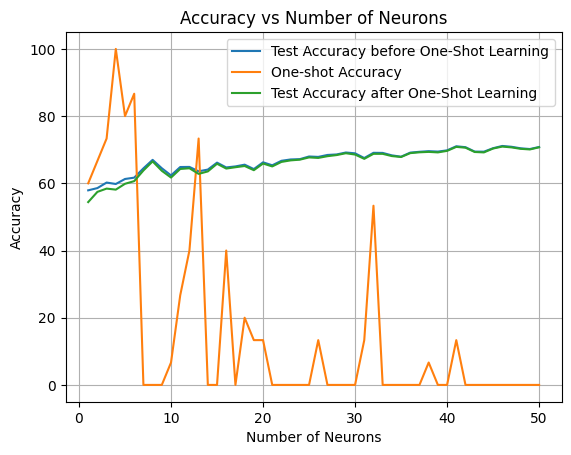

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming num_neurons is already defined
num_neurons = np.arange(1, 51)

# Plotting the accuracies
plt.plot(num_neurons, original_accuracy, label='Test Accuracy before One-Shot Learning')
plt.plot(num_neurons, one_shot_accuracy, label='One-shot Accuracy')
plt.plot(num_neurons, seven_classes_accuracy, label='Test Accuracy after One-Shot Learning')

plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neurons')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [46]:
original_accuracy

[57.912355447352404,
 58.58186244674376,
 60.225197808886186,
 59.79914790018259,
 61.29032258064516,
 61.68594035301278,
 64.45526475958613,
 66.98113207547169,
 64.48569689592209,
 62.35544735240414,
 64.85088253195374,
 64.88131466828972,
 63.57273280584297,
 64.09007912355447,
 66.15946439440049,
 64.72915398660986,
 65.03347534996956,
 65.55082166768108,
 64.24223980523433,
 66.2507608034084,
 65.36822884966524,
 66.70724284844796,
 67.10286062081558,
 67.1941570298235,
 67.98539257455873,
 67.86366402921485,
 68.4418746195983,
 68.59403530127815,
 69.17224589166159,
 68.92878880097383,
 67.52891052951917,
 69.08094948265368,
 69.0505173463177,
 68.32014607425441,
 67.9245283018868,
 69.14181375532563,
 69.38527084601338,
 69.56786366402922,
 69.44613511868533,
 69.81132075471699,
 71.02860620815581,
 70.75471698113208,
 69.44613511868533,
 69.41570298234936,
 70.45039561777237,
 71.11990261716373,
 70.87644552647596,
 70.4199634814364,
 70.2069385270846,
 70.81558125380401]

In [47]:
one_shot_accuracy

[60.0,
 66.66666666666666,
 73.33333333333333,
 100.0,
 80.0,
 86.66666666666667,
 0.0,
 0.0,
 0.0,
 6.666666666666667,
 26.666666666666668,
 40.0,
 73.33333333333333,
 0.0,
 0.0,
 40.0,
 0.0,
 20.0,
 13.333333333333334,
 13.333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 13.333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 13.333333333333334,
 53.333333333333336,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.666666666666667,
 0.0,
 0.0,
 13.333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [48]:
seven_classes_accuracy

[54.41265976871576,
 57.45587340231284,
 58.42970176506391,
 58.1253804017042,
 59.86001217285453,
 60.651247717589776,
 63.81618989653074,
 66.52465003043214,
 63.72489348752283,
 61.71637248934875,
 64.2726719415703,
 64.48569689592209,
 62.8119293974437,
 63.542300669507,
 65.82471089470481,
 64.39440048691418,
 64.79001825928181,
 65.15520389531345,
 63.90748630553865,
 65.88557516737674,
 65.03347534996956,
 66.37248934875228,
 66.82897139379185,
 67.04199634814364,
 67.711503347535,
 67.55934266585514,
 68.07668898356664,
 68.41144248326232,
 68.9592209373098,
 68.56360316494218,
 67.28545343883141,
 68.77662811929397,
 68.77662811929397,
 68.10712111990262,
 67.83323189287889,
 68.98965307364577,
 69.23311016433354,
 69.35483870967742,
 69.20267802799756,
 69.65916007303713,
 70.84601339013999,
 70.60255629945222,
 69.32440657334145,
 69.20267802799756,
 70.35909920876446,
 70.9373097991479,
 70.69385270846013,
 70.26780279975654,
 70.08520998174072,
 70.7242848447961]

In [49]:
from akida_models import load_model
from akida import AkidaUnsupervised
from akida import FullyConnected, SeparableConvolutional
from cnn2snn import quantize_layer
import os
from tensorflow.image import resize_with_crop_or_pad

num_neurons = [100, 150, 200, 250, 300, 350, 400, 450, 500]

original_accuracy = []
one_shot_accuracy = []
seven_classes_accuracy = []


for neuron in num_neurons:
    # Load model 
    model_path = 'model_akida.fbz'
    model_akida = load_model(model_path)

    num_classes = 7
    num_neurons_per_class = neuron
    num_weights = 512 
    model_akida.pop_layer()

    layer_fc = FullyConnected(name='akida_edge_layer',
                            units=num_classes * num_neurons_per_class,
                            activation=False)
    model_akida.add(layer_fc)

    model_akida.compile(optimizer=AkidaUnsupervised(num_weights=num_weights,
                                             num_classes=num_classes,
                                             learning_competition=0.1))
    
    batch_size = 32
    # Convert x_train_smote to uint8 if needed
    x_train_smote = x_train_smote.astype(np.uint8)

    # Convert one-hot encoded y_train_smote to class indices (integer labels)
    y_train_smote_int = np.argmax(y_train_smote, axis=1).astype(np.int32)


    num_batches = int(np.ceil(x_train.shape[0] / batch_size))
    for i in range(num_batches):
        s = slice(i * batch_size, (i + 1) * batch_size)
        model_akida.fit(x_train_smote[s], y_train_smote_int[s])

    model_akida.save(f"models/hundred/model_edge_trained_{neuron}.fbz")

    # Convert x_train_smote to uint8 if needed
    x_test = x_test.astype(np.uint8)

    # Evaluate the model on the test dataset
    predictions = np.zeros(x_test.shape[0])

    # Loop through the training data and get predictions
    for i in range(x_test.shape[0]):
        padded_image = resize_with_crop_or_pad(x_test[i], 64, 64)
        predictions[i] = model_akida.predict_classes(np.expand_dims(padded_image,
                                                                axis=0),
                                                num_classes=7)

    # Get true labels in a flat format
    true_labels = y_test_labels

    # Calculate overall accuracy
    before_accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)

    original_accuracy.append(before_accuracy)

    class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

    label = 'seborrheic_k'
    model_akida.add_classes(1)

    for file in os.listdir('seborrheic_k/'):
        image = load_and_convert_image(f"seborrheic_k/{file}")
        image = np.expand_dims(image, axis=0)  
        model_akida.fit(image, len(class_names))

    class_names.append(label)

    correct_predictions = 0
    total_images = 0

    for file in os.listdir('seborrheic_k/'):
        image = load_and_convert_image(f"seborrheic_k/{file}")
        true_label = 7  # Seborrheic keratosis corresponds to label 7

        padded_image = resize_with_crop_or_pad(image, 64, 64)
        predicted_label = model_akida.predict_classes(np.expand_dims(padded_image, axis=0), num_classes=7)

        if predicted_label[0] == true_label:
            correct_predictions += 1

        total_images += 1

    sebk_accuracy = correct_predictions / total_images if total_images > 0 else 0

    print(f"{correct_predictions}/{total_images}")
    one_shot_accuracy.append(sebk_accuracy * 100)

    # Evaluate the model on the test dataset
    predictions = np.zeros(x_test.shape[0])
    # Loop through the training data and get predictions
    for i in range(x_test.shape[0]):
        padded_image = resize_with_crop_or_pad(x_test[i], 64, 64)
        predictions[i] = model_akida.predict_classes(np.expand_dims(padded_image,
                                                                axis=0),
                                                num_classes=8)
    # Get true labels in a flat format
    true_labels = y_test_labels
    # Calculate overall accuracy
    after_accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)

    seven_classes_accuracy.append(after_accuracy)

    print(f"Neurons: {neuron}, Before Accuracy: {before_accuracy:.2f}%, One-shot Accuracy: {sebk_accuracy * 100:.2f}%, After Accuracy: {after_accuracy:.2f}%")

2/15
Neurons: 100, Before Accuracy: 73.49%, One-shot Accuracy: 13.33%, After Accuracy: 73.46%
0/15
Neurons: 150, Before Accuracy: 76.17%, One-shot Accuracy: 0.00%, After Accuracy: 76.14%
0/15
Neurons: 200, Before Accuracy: 74.92%, One-shot Accuracy: 0.00%, After Accuracy: 74.92%
0/15
Neurons: 250, Before Accuracy: 76.29%, One-shot Accuracy: 0.00%, After Accuracy: 76.20%
0/15
Neurons: 300, Before Accuracy: 75.75%, One-shot Accuracy: 0.00%, After Accuracy: 75.72%
0/15
Neurons: 350, Before Accuracy: 76.96%, One-shot Accuracy: 0.00%, After Accuracy: 76.96%
0/15
Neurons: 400, Before Accuracy: 77.24%, One-shot Accuracy: 0.00%, After Accuracy: 77.18%
0/15
Neurons: 450, Before Accuracy: 77.21%, One-shot Accuracy: 0.00%, After Accuracy: 77.21%
0/15
Neurons: 500, Before Accuracy: 77.75%, One-shot Accuracy: 0.00%, After Accuracy: 77.66%


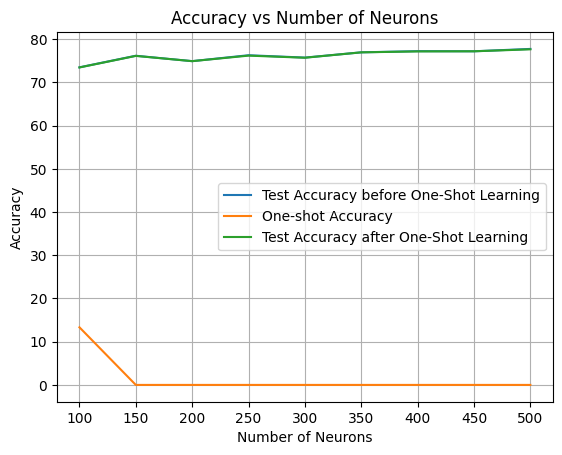

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming num_neurons is already defined
num_neurons = [100, 150, 200, 250, 300, 350, 400, 450, 500]

# Plotting the accuracies
plt.plot(num_neurons, original_accuracy, label='Test Accuracy before One-Shot Learning')
plt.plot(num_neurons, one_shot_accuracy, label='One-shot Accuracy')
plt.plot(num_neurons, seven_classes_accuracy, label='Test Accuracy after One-Shot Learning')

plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neurons')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [51]:
num_neurons = [550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]


for neuron in num_neurons:
    # Load model 
    model_path = 'model_akida.fbz'
    model_akida = load_model(model_path)

    num_classes = 7
    num_neurons_per_class = neuron
    num_weights = 512 
    model_akida.pop_layer()

    layer_fc = FullyConnected(name='akida_edge_layer',
                            units=num_classes * num_neurons_per_class,
                            activation=False)
    model_akida.add(layer_fc)

    model_akida.compile(optimizer=AkidaUnsupervised(num_weights=num_weights,
                                             num_classes=num_classes,
                                             learning_competition=0.1))
    
    batch_size = 32
    # Convert x_train_smote to uint8 if needed
    x_train_smote = x_train_smote.astype(np.uint8)

    # Convert one-hot encoded y_train_smote to class indices (integer labels)
    y_train_smote_int = np.argmax(y_train_smote, axis=1).astype(np.int32)


    num_batches = int(np.ceil(x_train.shape[0] / batch_size))
    for i in range(num_batches):
        s = slice(i * batch_size, (i + 1) * batch_size)
        model_akida.fit(x_train_smote[s], y_train_smote_int[s])

    model_akida.save(f"models/hundred/model_edge_trained_{neuron}.fbz")

    # Convert x_train_smote to uint8 if needed
    x_test = x_test.astype(np.uint8)

    # Evaluate the model on the test dataset
    predictions = np.zeros(x_test.shape[0])

    # Loop through the training data and get predictions
    for i in range(x_test.shape[0]):
        padded_image = resize_with_crop_or_pad(x_test[i], 64, 64)
        predictions[i] = model_akida.predict_classes(np.expand_dims(padded_image,
                                                                axis=0),
                                                num_classes=7)

    # Get true labels in a flat format
    true_labels = y_test_labels

    # Calculate overall accuracy
    before_accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)

    original_accuracy.append(before_accuracy)

    class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

    label = 'seborrheic_k'
    model_akida.add_classes(1)

    for file in os.listdir('seborrheic_k/'):
        image = load_and_convert_image(f"seborrheic_k/{file}")
        image = np.expand_dims(image, axis=0)  
        model_akida.fit(image, len(class_names))

    class_names.append(label)

    correct_predictions = 0
    total_images = 0

    for file in os.listdir('seborrheic_k/'):
        image = load_and_convert_image(f"seborrheic_k/{file}")
        true_label = 7  # Seborrheic keratosis corresponds to label 7

        padded_image = resize_with_crop_or_pad(image, 64, 64)
        predicted_label = model_akida.predict_classes(np.expand_dims(padded_image, axis=0), num_classes=7)

        if predicted_label[0] == true_label:
            correct_predictions += 1

        total_images += 1

    sebk_accuracy = correct_predictions / total_images if total_images > 0 else 0

    print(f"{correct_predictions}/{total_images}")
    one_shot_accuracy.append(sebk_accuracy * 100)

    # Evaluate the model on the test dataset
    predictions = np.zeros(x_test.shape[0])
    # Loop through the training data and get predictions
    for i in range(x_test.shape[0]):
        padded_image = resize_with_crop_or_pad(x_test[i], 64, 64)
        predictions[i] = model_akida.predict_classes(np.expand_dims(padded_image,
                                                                axis=0),
                                                num_classes=8)
    # Get true labels in a flat format
    true_labels = y_test_labels
    # Calculate overall accuracy
    after_accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)

    seven_classes_accuracy.append(after_accuracy)

    print(f"Neurons: {neuron}, Before Accuracy: {before_accuracy:.2f}%, One-shot Accuracy: {sebk_accuracy * 100:.2f}%, After Accuracy: {after_accuracy:.2f}%")

0/15
Neurons: 550, Before Accuracy: 76.63%, One-shot Accuracy: 0.00%, After Accuracy: 76.54%
0/15
Neurons: 600, Before Accuracy: 76.26%, One-shot Accuracy: 0.00%, After Accuracy: 76.26%
0/15
Neurons: 650, Before Accuracy: 76.66%, One-shot Accuracy: 0.00%, After Accuracy: 76.66%
0/15
Neurons: 700, Before Accuracy: 76.75%, One-shot Accuracy: 0.00%, After Accuracy: 76.75%
0/15
Neurons: 750, Before Accuracy: 76.99%, One-shot Accuracy: 0.00%, After Accuracy: 76.90%
0/15
Neurons: 800, Before Accuracy: 76.78%, One-shot Accuracy: 0.00%, After Accuracy: 76.75%
0/15
Neurons: 850, Before Accuracy: 76.05%, One-shot Accuracy: 0.00%, After Accuracy: 76.02%
0/15
Neurons: 900, Before Accuracy: 76.90%, One-shot Accuracy: 0.00%, After Accuracy: 76.87%
0/15
Neurons: 950, Before Accuracy: 77.27%, One-shot Accuracy: 0.00%, After Accuracy: 77.21%
0/15
Neurons: 1000, Before Accuracy: 77.48%, One-shot Accuracy: 0.00%, After Accuracy: 77.39%


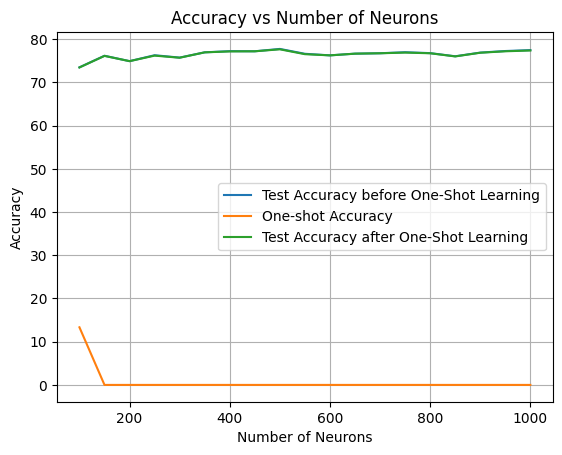

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming num_neurons is already defined
num_neurons = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

# Plotting the accuracies
plt.plot(num_neurons, original_accuracy, label='Test Accuracy before One-Shot Learning')
plt.plot(num_neurons, one_shot_accuracy, label='One-shot Accuracy')
plt.plot(num_neurons, seven_classes_accuracy, label='Test Accuracy after One-Shot Learning')

plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neurons')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [53]:
original_accuracy

[73.49360925136945,
 76.17163724893487,
 74.92391965916008,
 76.29336579427876,
 75.74558734023128,
 76.96287279367012,
 77.23676202069386,
 77.20632988435788,
 77.75410833840536,
 76.62811929397444,
 76.26293365794278,
 76.65855143031041,
 76.74984783931832,
 76.99330493000609,
 76.7802799756543,
 76.04990870359099,
 76.90200852099818,
 77.26719415702982,
 77.48021911138161]

In [54]:
one_shot_accuracy

[13.333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [55]:
seven_classes_accuracy

[73.46317711503347,
 76.14120511259891,
 74.92391965916008,
 76.20206938527085,
 75.7151552038953,
 76.96287279367012,
 77.17589774802191,
 77.20632988435788,
 77.66281192939745,
 76.53682288496653,
 76.26293365794278,
 76.65855143031041,
 76.74984783931832,
 76.90200852099818,
 76.74984783931832,
 76.01947656725503,
 76.8715763846622,
 77.20632988435788,
 77.3889227023737]

In [56]:
num_neurons = [1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


for neuron in num_neurons:
    # Load model 
    model_path = 'model_akida.fbz'
    model_akida = load_model(model_path)

    num_classes = 7
    num_neurons_per_class = neuron
    num_weights = 512 
    model_akida.pop_layer()

    layer_fc = FullyConnected(name='akida_edge_layer',
                            units=num_classes * num_neurons_per_class,
                            activation=False)
    model_akida.add(layer_fc)

    model_akida.compile(optimizer=AkidaUnsupervised(num_weights=num_weights,
                                             num_classes=num_classes,
                                             learning_competition=0.1))
    
    batch_size = 32
    # Convert x_train_smote to uint8 if needed
    x_train_smote = x_train_smote.astype(np.uint8)

    # Convert one-hot encoded y_train_smote to class indices (integer labels)
    y_train_smote_int = np.argmax(y_train_smote, axis=1).astype(np.int32)


    num_batches = int(np.ceil(x_train.shape[0] / batch_size))
    for i in range(num_batches):
        s = slice(i * batch_size, (i + 1) * batch_size)
        model_akida.fit(x_train_smote[s], y_train_smote_int[s])

    model_akida.save(f"models/hundred/model_edge_trained_{neuron}.fbz")

    # Convert x_train_smote to uint8 if needed
    x_test = x_test.astype(np.uint8)

    # Evaluate the model on the test dataset
    predictions = np.zeros(x_test.shape[0])

    # Loop through the training data and get predictions
    for i in range(x_test.shape[0]):
        padded_image = resize_with_crop_or_pad(x_test[i], 64, 64)
        predictions[i] = model_akida.predict_classes(np.expand_dims(padded_image,
                                                                axis=0),
                                                num_classes=7)

    # Get true labels in a flat format
    true_labels = y_test_labels

    # Calculate overall accuracy
    before_accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)

    original_accuracy.append(before_accuracy)

    class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

    label = 'seborrheic_k'
    model_akida.add_classes(1)

    for file in os.listdir('seborrheic_k/'):
        image = load_and_convert_image(f"seborrheic_k/{file}")
        image = np.expand_dims(image, axis=0)  
        model_akida.fit(image, len(class_names))

    class_names.append(label)

    correct_predictions = 0
    total_images = 0

    for file in os.listdir('seborrheic_k/'):
        image = load_and_convert_image(f"seborrheic_k/{file}")
        true_label = 7  # Seborrheic keratosis corresponds to label 7

        padded_image = resize_with_crop_or_pad(image, 64, 64)
        predicted_label = model_akida.predict_classes(np.expand_dims(padded_image, axis=0), num_classes=7)

        if predicted_label[0] == true_label:
            correct_predictions += 1

        total_images += 1

    sebk_accuracy = correct_predictions / total_images if total_images > 0 else 0

    print(f"{correct_predictions}/{total_images}")
    one_shot_accuracy.append(sebk_accuracy * 100)

    # Evaluate the model on the test dataset
    predictions = np.zeros(x_test.shape[0])
    # Loop through the training data and get predictions
    for i in range(x_test.shape[0]):
        padded_image = resize_with_crop_or_pad(x_test[i], 64, 64)
        predictions[i] = model_akida.predict_classes(np.expand_dims(padded_image,
                                                                axis=0),
                                                num_classes=8)
    # Get true labels in a flat format
    true_labels = y_test_labels
    # Calculate overall accuracy
    after_accuracy = 100 * np.sum(predictions == true_labels) / len(true_labels)

    seven_classes_accuracy.append(after_accuracy)

    print(f"Neurons: {neuron}, Before Accuracy: {before_accuracy:.2f}%, One-shot Accuracy: {sebk_accuracy * 100:.2f}%, After Accuracy: {after_accuracy:.2f}%")

0/15
Neurons: 1500, Before Accuracy: 76.93%, One-shot Accuracy: 0.00%, After Accuracy: 76.84%
0/15
Neurons: 2000, Before Accuracy: 76.57%, One-shot Accuracy: 0.00%, After Accuracy: 76.48%
0/15
Neurons: 2500, Before Accuracy: 76.96%, One-shot Accuracy: 0.00%, After Accuracy: 76.93%
0/15
Neurons: 3000, Before Accuracy: 77.39%, One-shot Accuracy: 0.00%, After Accuracy: 77.30%
0/15
Neurons: 3500, Before Accuracy: 76.78%, One-shot Accuracy: 0.00%, After Accuracy: 76.75%
0/15
Neurons: 4000, Before Accuracy: 77.94%, One-shot Accuracy: 0.00%, After Accuracy: 77.94%
0/15
Neurons: 4500, Before Accuracy: 77.36%, One-shot Accuracy: 0.00%, After Accuracy: 77.33%
0/15
Neurons: 5000, Before Accuracy: 78.24%, One-shot Accuracy: 0.00%, After Accuracy: 78.18%


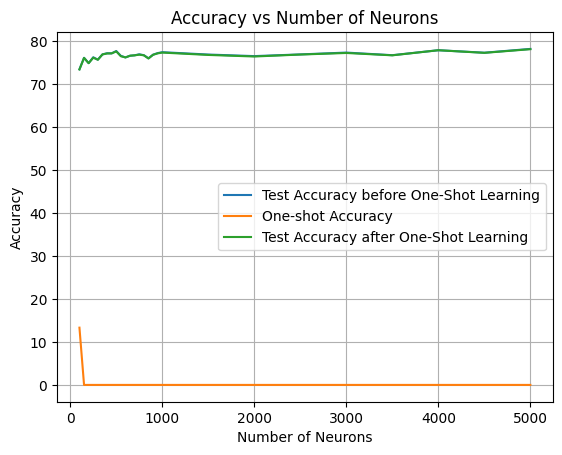

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming num_neurons is already defined
num_neurons = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

# Plotting the accuracies
plt.plot(num_neurons, original_accuracy, label='Test Accuracy before One-Shot Learning')
plt.plot(num_neurons, one_shot_accuracy, label='One-shot Accuracy')
plt.plot(num_neurons, seven_classes_accuracy, label='Test Accuracy after One-Shot Learning')

plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neurons')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [58]:
original_accuracy

[73.49360925136945,
 76.17163724893487,
 74.92391965916008,
 76.29336579427876,
 75.74558734023128,
 76.96287279367012,
 77.23676202069386,
 77.20632988435788,
 77.75410833840536,
 76.62811929397444,
 76.26293365794278,
 76.65855143031041,
 76.74984783931832,
 76.99330493000609,
 76.7802799756543,
 76.04990870359099,
 76.90200852099818,
 77.26719415702982,
 77.48021911138161,
 76.93244065733414,
 76.5672550213025,
 76.96287279367012,
 77.3889227023737,
 76.7802799756543,
 77.93670115642118,
 77.35849056603773,
 78.24102251978088]

In [59]:
one_shot_accuracy

[13.333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [60]:
seven_classes_accuracy

[73.46317711503347,
 76.14120511259891,
 74.92391965916008,
 76.20206938527085,
 75.7151552038953,
 76.96287279367012,
 77.17589774802191,
 77.20632988435788,
 77.66281192939745,
 76.53682288496653,
 76.26293365794278,
 76.65855143031041,
 76.74984783931832,
 76.90200852099818,
 76.74984783931832,
 76.01947656725503,
 76.8715763846622,
 77.20632988435788,
 77.3889227023737,
 76.84114424832623,
 76.47595861229458,
 76.93244065733414,
 77.2976262933658,
 76.74984783931832,
 77.93670115642118,
 77.32805842970177,
 78.18015824710895]

In [61]:
original_otf = [57.912355447352404,
58.58186244674376,
60.225197808886186,
59.79914790018259,
61.29032258064516,
61.68594035301278,
64.45526475958613,
66.98113207547169,
64.48569689592209,
62.35544735240414,
64.85088253195374,
64.88131466828972,
63.57273280584297,
64.09007912355447,
66.15946439440049,
64.72915398660986,
65.03347534996956,
65.55082166768108,
64.24223980523433,
66.2507608034084,
65.36822884966524,
66.70724284844796,
67.10286062081558,
67.1941570298235,
67.98539257455873,
67.86366402921485,
68.4418746195983,
68.59403530127815,
69.17224589166159,
68.92878880097383,
67.52891052951917,
69.08094948265368,
69.0505173463177,
68.32014607425441,
67.9245283018868,
69.14181375532563,
69.38527084601338,
69.56786366402922,
69.44613511868533,
69.81132075471699,
71.02860620815581,
70.75471698113208,
69.44613511868533,
69.41570298234936,
70.45039561777237,
71.11990261716373,
70.87644552647596,
70.4199634814364,
70.2069385270846,
70.81558125380401]


seven_classes_otf = [54.41265976871576,
57.45587340231284,
58.42970176506391,
58.1253804017042,
59.86001217285453,
60.651247717589776,
63.81618989653074,
66.52465003043214,
63.72489348752283,
61.71637248934875,
64.2726719415703,
64.48569689592209,
62.8119293974437,
63.542300669507,
65.82471089470481,
64.39440048691418,
64.79001825928181,
65.15520389531345,
63.90748630553865,
65.88557516737674,
65.03347534996956,
66.37248934875228,
66.82897139379185,
67.04199634814364,
67.711503347535,
67.55934266585514,
68.07668898356664,
68.41144248326232,
68.9592209373098,
68.56360316494218,
67.28545343883141,
68.77662811929397,
68.77662811929397,
68.10712111990262,
67.83323189287889,
68.98965307364577,
69.23311016433354,
69.35483870967742,
69.20267802799756,
69.65916007303713,
70.84601339013999,
70.60255629945222,
69.32440657334145,
69.20267802799756,
70.35909920876446,
70.9373097991479,
70.69385270846013,
70.26780279975654,
70.08520998174072,
70.7242848447961]

In [64]:
merged_original = np.concatenate((original_otf, original_accuracy))
merged_seven_class = np.concatenate((seven_classes_otf, seven_classes_accuracy))

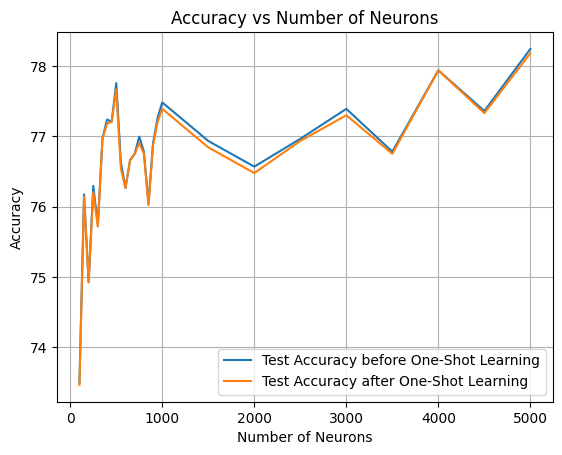

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming num_neurons is already defined
num_neurons1 = np.arange(1, 51)
num_neurons = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
merged_neurons = np.concatenate((num_neurons1, num_neurons))

# Plotting the accuracies
plt.plot(num_neurons, original_accuracy, label='Test Accuracy before One-Shot Learning')
plt.plot(num_neurons, seven_classes_accuracy, label='Test Accuracy after One-Shot Learning')

plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neurons')
plt.legend()
plt.grid(True)

# Show plot
plt.show()